<a href="https://colab.research.google.com/github/Esubaalew/compare-optimization-algorithms/blob/main/com.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import time

np.random.seed(42)
tf.random.set_seed(42)

# --- Constants ---
EPOCHS = 15
COMMON_LR = 0.01 # Common learning rate for SGD variants and initial for adaptive
MOMENTUM_VAL = 0.9
# Batch sizes for TFDS pipeline (used by Minibatch SGD and Adaptive optimizers directly)
TFDS_MINIBATCH_SIZE = 32
# Batch size for Stochastic GD
BATCH_SIZE_STOCHASTIC = 1
# Batch size for true Batch GD will be the full training set size.

print(f"TensorFlow Version: {tf.__version__}")
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

TensorFlow Version: 2.18.0
Num GPUs Available: 2


Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

Converting datasets to NumPy arrays for Batch GD / Stochastic GD...
x_train_full_np shape: (21600, 64, 64, 3)
y_train_full_np shape: (21600, 10)
x_test_np shape: (5400, 64, 64, 3)
y_test_np shape: (5400, 10)
Batch size for GD (Full Batch): 21600


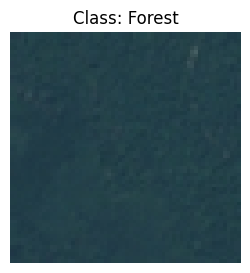


Sample batch - Image batch shape: (32, 64, 64, 3), Label batch shape: (32, 10)


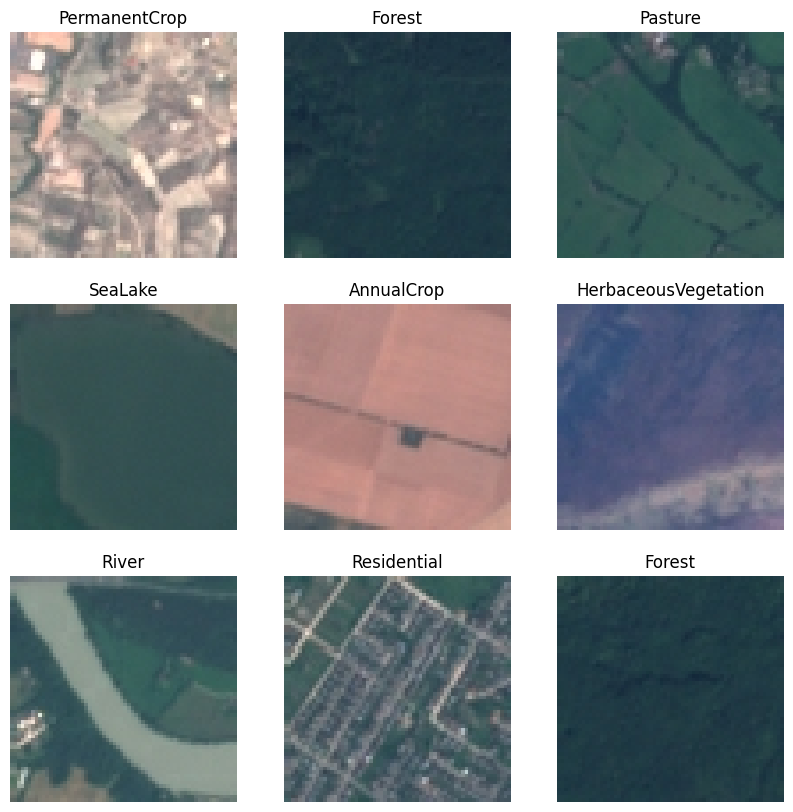

In [ ]:

(ds_train_tfds_orig, ds_test_tfds_orig), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,  # Returns (image, label) tuples
    with_info=True,
)

num_classes = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


def preprocess(image, label):
    # EuroSAT images from TFDS are already 64x64 and uint8
    image = tf.cast(image, tf.float32) / 255.0 # Normalize pixel values to [0, 1]
    label = tf.one_hot(label, depth=num_classes) # One-hot encode the labels
    return image, label


ds_train_minibatch = ds_train_tfds_orig.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                                .cache()\
                                .shuffle(ds_info.splits['train'].num_examples // 10)\
                                .batch(TFDS_MINIBATCH_SIZE)\
                                .prefetch(tf.data.AUTOTUNE)

ds_test_minibatch = ds_test_tfds_orig.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)\
                               .cache()\
                               .batch(TFDS_MINIBATCH_SIZE)\
                               .prefetch(tf.data.AUTOTUNE)

# --- Prepare data as NumPy arrays for Batch GD and Stochastic GD ---
print("\nConverting datasets to NumPy arrays for Batch GD / Stochastic GD...")

# Training data to NumPy
x_train_full_list = []
y_train_full_list = []
for image, label in ds_train_tfds_orig.map(preprocess):
    x_train_full_list.append(image.numpy())
    y_train_full_list.append(label.numpy())
x_train_full_np = np.array(x_train_full_list)
y_train_full_np = np.array(y_train_full_list)

# Test data to NumPy
x_test_list = []
y_test_list = []
for image, label in ds_test_tfds_orig.map(preprocess):
    x_test_list.append(image.numpy())
    y_test_list.append(label.numpy())
x_test_np = np.array(x_test_list)
y_test_np = np.array(y_test_list)

BATCH_SIZE_GD = len(x_train_full_np)

print(f"x_train_full_np shape: {x_train_full_np.shape}")
print(f"y_train_full_np shape: {y_train_full_np.shape}")
print(f"x_test_np shape: {x_test_np.shape}")
print(f"y_test_np shape: {y_test_np.shape}")
print(f"Batch size for GD (Full Batch): {BATCH_SIZE_GD}")

# Display a sample image from the NumPy array
plt.figure(figsize=(3,3))
plt.imshow(x_train_full_np[0])
plt.title(f"Class: {class_names[np.argmax(y_train_full_np[0])]}")
plt.axis('off')
plt.show()


for images_batch, labels_batch in ds_train_minibatch.take(1):
    plt.figure(figsize=(10, 10))
    print(f"\nSample batch - Image batch shape: {images_batch.shape}, Label batch shape: {labels_batch.shape}")
    for i in range(min(9, images_batch.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images_batch[i].numpy())
        plt.title(class_names[np.argmax(labels_batch[i].numpy())])
        plt.axis("off")
    plt.show()
    break

In [ ]:
IMG_HEIGHT = 64
IMG_WIDTH = 64
CHANNELS = 3

def create_simple_mlp_eurosat(input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS), num_classes_mlp=num_classes):
    """Creates a simple MLP model for EuroSAT."""
    inputs = Input(shape=input_shape)
    flattened = Flatten()(inputs)
    hidden1 = Dense(128, activation='relu', kernel_initializer='he_normal')(flattened)
    hidden2 = Dense(64, activation='relu', kernel_initializer='he_normal')(hidden1)
    outputs = Dense(num_classes_mlp, activation='softmax')(hidden2)
    model = Model(inputs=inputs, outputs=outputs)
    return model


model_test = create_simple_mlp_eurosat()
model_test.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12288)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,898 (6.03 MB)

 Trainable params: 1,581,898 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
results_history = {}

def train_and_evaluate(optimizer_name, optimizer_instance,
                       train_data_x=None, train_data_y=None,
                       train_dataset=None,
                       test_data_x=x_test_np, test_data_y=y_test_np,
                       test_dataset=ds_test_minibatch,
                       batch_size_fit=None,
                       is_tfdata_input=False):
    """Trains a model with a given optimizer and evaluates it."""
    print(f"\n--- Training with: {optimizer_name} ---")
    print(f"Optimizer config: {optimizer_instance.get_config()}")
    if not is_tfdata_input and batch_size_fit:
        print(f"Effective Batch Size for .fit(): {batch_size_fit}")
    elif is_tfdata_input:

        if hasattr(train_dataset, 'element_spec') and len(train_dataset.element_spec) > 0:
            if hasattr(train_dataset.element_spec[0], 'shape') and train_dataset.element_spec[0].shape.rank > 0:

                 example_batch_shape = train_dataset.element_spec[0].shape
                 if example_batch_shape[0] is not None:
                     print(f"Batch Size from tf.data.Dataset pipeline: {example_batch_shape[0]}")
                 else:
                     print(f"Batch Size from tf.data.Dataset pipeline: {TFDS_MINIBATCH_SIZE} (configured)")


    model = create_simple_mlp_eurosat()
    model.compile(optimizer=optimizer_instance,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    start_time = time.time()
    if is_tfdata_input:
        if train_dataset is None:
            raise ValueError("train_dataset must be provided when is_tfdata_input is True.")
        history = model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=test_dataset,
                            verbose=1)
    else:
        if train_data_x is None or train_data_y is None:
            raise ValueError("train_data_x and train_data_y must be provided when is_tfdata_input is False.")
        history = model.fit(train_data_x, train_data_y,
                            epochs=EPOCHS,
                            batch_size=batch_size_fit,
                            validation_data=(test_data_x, test_data_y),
                            verbose=1)
    training_time = time.time() - start_time

    if is_tfdata_input:
        if test_dataset is None:
            raise ValueError("test_dataset must be provided for evaluation when is_tfdata_input is True.")
        loss, accuracy = model.evaluate(test_dataset, verbose=0)
        y_pred_proba = model.predict(test_dataset, verbose=0)
        y_true_classes_list = []
        for _, labels_batch_eval in test_dataset:
            y_true_classes_list.append(np.argmax(labels_batch_eval.numpy(), axis=1))
        y_true_classes_eval = np.concatenate(y_true_classes_list)

        y_pred_classes_eval = np.argmax(y_pred_proba, axis=1)[:len(y_true_classes_eval)]
    else:
        loss, accuracy = model.evaluate(test_data_x, test_data_y, verbose=0)
        y_pred_proba = model.predict(test_data_x, verbose=0)
        y_true_classes_eval = np.argmax(test_data_y, axis=1)
        y_pred_classes_eval = np.argmax(y_pred_proba, axis=1)

    f1 = f1_score(y_true_classes_eval, y_pred_classes_eval, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (weighted): {f1:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")


    reported_batch_size = "N/A"
    if is_tfdata_input:
        if hasattr(train_dataset, 'element_spec') and len(train_dataset.element_spec) > 0:
            if hasattr(train_dataset.element_spec[0], 'shape') and train_dataset.element_spec[0].shape.rank > 0:
                 example_batch_shape_rep = train_dataset.element_spec[0].shape
                 if example_batch_shape_rep[0] is not None:
                     reported_batch_size = f"{example_batch_shape_rep[0]} (tf.data)"
                 else:
                     reported_batch_size = f"{TFDS_MINIBATCH_SIZE} (tf.data configured)"
        else:
            reported_batch_size = f"{TFDS_MINIBATCH_SIZE} (tf.data default)"


    elif batch_size_fit is not None:
        reported_batch_size = str(batch_size_fit)


    results_history[optimizer_name] = {
        'optimizer_name': optimizer_name,
        'history': history.history,
        'test_accuracy': accuracy,
        'test_f1_score': f1,
        'training_time': training_time,
        'batch_size_config': reported_batch_size
    }
    return results_history[optimizer_name]

# Run Experiments - Part I Algorithms

In [ ]:
print("===========================================")
print("========= PART I ALGORITHMS START =========")
print("===========================================")

opt_gd = keras.optimizers.SGD(learning_rate=COMMON_LR)
train_and_evaluate("GD (Batch)", opt_gd,
                   train_data_x=x_train_full_np, train_data_y=y_train_full_np,
                   batch_size_fit=BATCH_SIZE_GD,
                   is_tfdata_input=False)

opt_minibatch_sgd = keras.optimizers.SGD(learning_rate=COMMON_LR)
train_and_evaluate("Minibatch SGD", opt_minibatch_sgd,
                   train_dataset=ds_train_minibatch,
                   test_dataset=ds_test_minibatch,
                   is_tfdata_input=True)

opt_stochastic_gd = keras.optimizers.SGD(learning_rate=COMMON_LR)
train_and_evaluate("Stochastic GD", opt_stochastic_gd,
                   train_data_x=x_train_full_np, train_data_y=y_train_full_np,
                   batch_size_fit=BATCH_SIZE_STOCHASTIC,
                   is_tfdata_input=False)

print("=========================================")
print("========= PART I ALGORITHMS END =========")
print("=========================================")

========= PART I ALGORITHMS START =========

--- Training with: GD (Batch) ---
Optimizer config: {'name': 'SGD', 'learning_rate': 0.009999999776482582, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.0, 'nesterov': False}
Effective Batch Size for .fit(): 21600
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1119 - loss: 2.3834 - val_accuracy: 0.0944 - val_loss: 2.4031
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0936 - loss: 2.4084 - val_accuracy: 0.0937 - val_loss: 2.3808
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0956 - loss: 2.3796 - val_accuracy: 0.1159 - val_loss: 2.2695
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1069 - loss: 2.2692 - val_accuracy: 0.1119 - val_loss: 2.2460
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0

# Run Experiments - Part II Algorithms

In [ ]:
print("\n============================================")
print("========= PART II ALGORITHMS START =========")
print("============================================")

# 4. Gradient Descent (This is the same as #1, results_history['GD (Batch)'] can be used for comparison)

if "GD (Batch)" not in results_history:
    print("Re-running GD (Batch) as it was not found in results_history (should ideally be present from Part I).")
    opt_gd_part2 = keras.optimizers.SGD(learning_rate=COMMON_LR)
    train_and_evaluate("GD (Batch)", opt_gd_part2,
                       train_data_x=x_train_full_np, train_data_y=y_train_full_np,
                       batch_size_fit=BATCH_SIZE_GD,
                       is_tfdata_input=False)
else:
    print("GD (Batch) results already available from Part I for Part II comparison.")



opt_gd_momentum = keras.optimizers.SGD(learning_rate=COMMON_LR, momentum=MOMENTUM_VAL)
train_and_evaluate("GD with Momentum (Batch)", opt_gd_momentum,
                   train_data_x=x_train_full_np, train_data_y=y_train_full_np,
                   batch_size_fit=BATCH_SIZE_GD,
                   is_tfdata_input=False)


opt_gd_nesterov = keras.optimizers.SGD(learning_rate=COMMON_LR, momentum=MOMENTUM_VAL, nesterov=True)
train_and_evaluate("GD with Nesterov Momentum (Batch)", opt_gd_nesterov,
                   train_data_x=x_train_full_np, train_data_y=y_train_full_np,
                   batch_size_fit=BATCH_SIZE_GD,
                   is_tfdata_input=False)

print("==========================================")
print("========= PART II ALGORITHMS END =========")
print("==========================================")


========= PART II ALGORITHMS START =========
GD (Batch) results already available from Part I for Part II comparison.

--- Training with: GD with Momentum (Batch) ---
Optimizer config: {'name': 'SGD', 'learning_rate': 0.009999999776482582, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.9, 'nesterov': False}
Effective Batch Size for .fit(): 21600
Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.0968 - loss: 2.3736 - val_accuracy: 0.0991 - val_loss: 2.3012
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1050 - loss: 2.2975 - val_accuracy: 0.1054 - val_loss: 2.2763
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1022 - loss: 2.2738 - val_accuracy: 0.1193 - val_loss: 2.2504
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1199 - loss: 2.2495 - val_accurac

# Run Experiments - Part III Algorithms

In [ ]:
print("\n=============================================")
print("========= PART III ALGORITHMS START =========")
print("=============================================")


opt_adagrad = keras.optimizers.Adagrad(learning_rate=COMMON_LR)
train_and_evaluate("AdaGrad", opt_adagrad,
                   train_dataset=ds_train_minibatch,
                   test_dataset=ds_test_minibatch,
                   is_tfdata_input=True)


opt_rmsprop = keras.optimizers.RMSprop(learning_rate=COMMON_LR)
train_and_evaluate("RMSprop", opt_rmsprop,
                   train_dataset=ds_train_minibatch,
                   test_dataset=ds_test_minibatch,
                   is_tfdata_input=True)


opt_adam = keras.optimizers.Adam(learning_rate=COMMON_LR)
train_and_evaluate("Adam", opt_adam,
                   train_dataset=ds_train_minibatch,
                   test_dataset=ds_test_minibatch,
                   is_tfdata_input=True)

print("===========================================")
print("========= PART III ALGORITHMS END =========")
print("===========================================")


========= PART III ALGORITHMS START =========

--- Training with: AdaGrad ---
Optimizer config: {'name': 'adagrad', 'learning_rate': 0.009999999776482582, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'initial_accumulator_value': 0.1, 'epsilon': 1e-07}
Batch Size from tf.data.Dataset pipeline: 32 (configured)
Epoch 1/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.2320 - loss: 2.0083 - val_accuracy: 0.3794 - val_loss: 1.6785
Epoch 2/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3749 - loss: 1.6823 - val_accuracy: 0.4041 - val_loss: 1.6538
Epoch 3/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4042 - loss: 1.6119 - val_accuracy: 0.4580 - val_loss: 1.5458
Epoch 4/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4168 - loss: 1.5619 - val_accuracy: 0.3956 - val_loss: 1.5393
E

# Consolidate Results into DataFrame

In [ ]:

results_df = pd.DataFrame([{
    'Optimizer': r['optimizer_name'],
    'Batch Size Config': r['batch_size_config'],
    'Accuracy': r['test_accuracy'],
    'F1 Score': r['test_f1_score'],
    'Training Time (s)': r['training_time']
} for r_key, r in results_history.items()])

print("\n\n--- Overall Performance Summary (Initial - Unsorted) ---")
print(results_df)

print("\n--- Overall Performance Summary (Sorted by F1 Score) ---")
print(results_df.sort_values(by='F1 Score', ascending=False))



--- Overall Performance Summary (Initial - Unsorted) ---
                           Optimizer        Batch Size Config  Accuracy  \
0                         GD (Batch)                    21600  0.205556   
1                      Minibatch SGD  32 (tf.data configured)  0.565370   
2                      Stochastic GD                        1  0.106111   
3           GD with Momentum (Batch)                    21600  0.273519   
4  GD with Nesterov Momentum (Batch)                    21600  0.241852   
5                            AdaGrad  32 (tf.data configured)  0.482778   
6                            RMSprop  32 (tf.data configured)  0.112593   
7                               Adam  32 (tf.data configured)  0.450926   

   F1 Score  Training Time (s)  
0  0.108335          27.860307  
1  0.555079          30.728528  
2  0.020359         766.180162  
3  0.208905          28.193289  
4  0.148987          28.029728  
5  0.467970          30.978930  
6  0.022788          31.247896  
7

# Visualization Functions

In [ ]:
def plot_training_history(histories_dict, title_suffix, metrics=['loss', 'accuracy']):
    """Plots training and validation loss and accuracy from Keras History objects."""
    plt.figure(figsize=(14, 5 * len(metrics)))
    for i, metric in enumerate(metrics):
        plt.subplot(len(metrics), 1, i + 1)
        for name, result_data in histories_dict.items():
            history_data = result_data['history']
            if metric in history_data and f'val_{metric}' in history_data:
                plt.plot(history_data[metric], label=f'{name} Train {metric.capitalize()}', lw=2)
                plt.plot(history_data[f'val_{metric}'], label=f'{name} Val {metric.capitalize()}', linestyle='--', lw=2)
            elif metric in history_data:
                 plt.plot(history_data[metric], label=f'{name} Train {metric.capitalize()}', lw=2)

        plt.title(f'Training and Validation {metric.capitalize()} - {title_suffix}', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.xticks(np.arange(0, EPOCHS, 1 if EPOCHS <=20 else EPOCHS//10))
    plt.tight_layout()
    plt.show()

def plot_comparison_bar_chart(df_to_plot, chart_title, sort_by_metric='F1 Score'):
    """Plots a bar chart comparing optimizers based on Accuracy and F1 Score."""
    df_sorted = df_to_plot.sort_values(by=sort_by_metric, ascending=False).reset_index(drop=True)

    n_optimizers = len(df_sorted)
    index = np.arange(n_optimizers)
    bar_width = 0.35

    fig, ax1 = plt.subplots(figsize=(max(10, n_optimizers * 1.5), 7))

    rects1 = ax1.bar(index - bar_width/2, df_sorted['Accuracy'], bar_width,
                     label='Accuracy', color='cornflowerblue', edgecolor='black')


    rects2 = ax1.bar(index + bar_width/2, df_sorted['F1 Score'], bar_width,
                     label='F1 Score', color='salmon', edgecolor='black')

    ax1.set_xlabel('Optimizer', fontsize=14)
    ax1.set_ylabel('Score', fontsize=14)
    ax1.set_title(chart_title, fontsize=16)
    ax1.set_xticks(index)
    ax1.set_xticklabels(df_sorted['Optimizer'], rotation=45, ha="right", fontsize=12)
    ax1.legend(loc='lower right', fontsize=12)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.tick_params(axis='both', which='major', labelsize=12)


    def autolabel(rects, ax_to_use):
        for rect in rects:
            height = rect.get_height()
            ax_to_use.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)

    autolabel(rects1, ax1)
    autolabel(rects2, ax1)

    plt.ylim(0, max(1.0, df_sorted[[ 'Accuracy', 'F1 Score']].max().max() * 1.1) )
    plt.show()

print("Visualization functions defined.")

Visualization functions defined.


# Comparison a) Part-I Algorithms



--- Comparison: Part-I Algorithms ---
       Optimizer        Batch Size Config  Accuracy  F1 Score  \
1  Minibatch SGD  32 (tf.data configured)  0.565370  0.555079   
0     GD (Batch)                    21600  0.205556  0.108335   
2  Stochastic GD                        1  0.106111  0.020359   

   Training Time (s)  
1          30.728528  
0          27.860307  
2         766.180162  


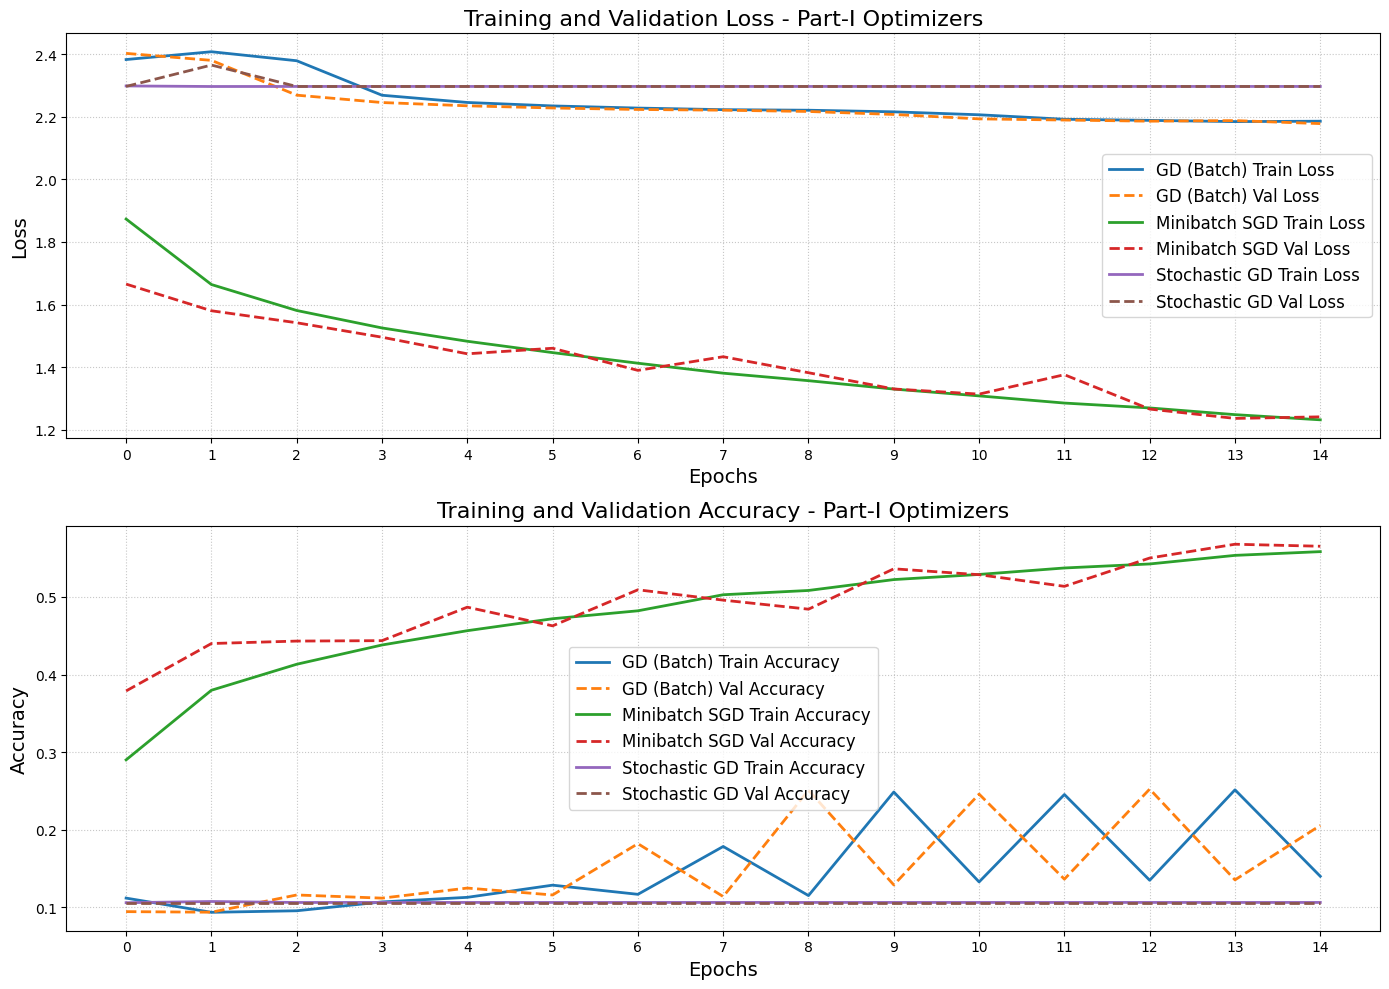

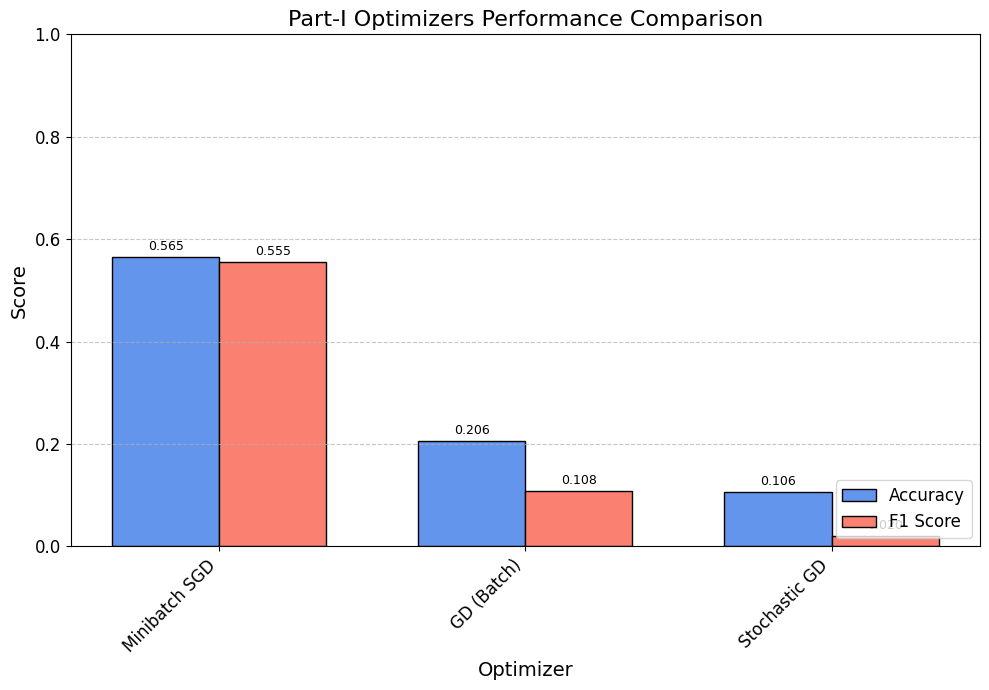

In [ ]:
part1_names = ['GD (Batch)', 'Minibatch SGD', 'Stochastic GD']

part1_histories_to_plot = {name: results_history[name] for name in part1_names if name in results_history}
part1_df = results_df[results_df['Optimizer'].isin(part1_names)]

print("\n\n--- Comparison: Part-I Algorithms ---")
print(part1_df.sort_values(by='F1 Score', ascending=False))

if part1_histories_to_plot:
    plot_training_history(part1_histories_to_plot, "Part-I Optimizers")
plot_comparison_bar_chart(part1_df, "Part-I Optimizers Performance Comparison")

# Comparison b) Part-II Algorithms



--- Comparison: Part-II Algorithms ---
                           Optimizer Batch Size Config  Accuracy  F1 Score  \
3           GD with Momentum (Batch)             21600  0.273519  0.208905   
4  GD with Nesterov Momentum (Batch)             21600  0.241852  0.148987   
0                         GD (Batch)             21600  0.205556  0.108335   

   Training Time (s)  
3          28.193289  
4          28.029728  
0          27.860307  


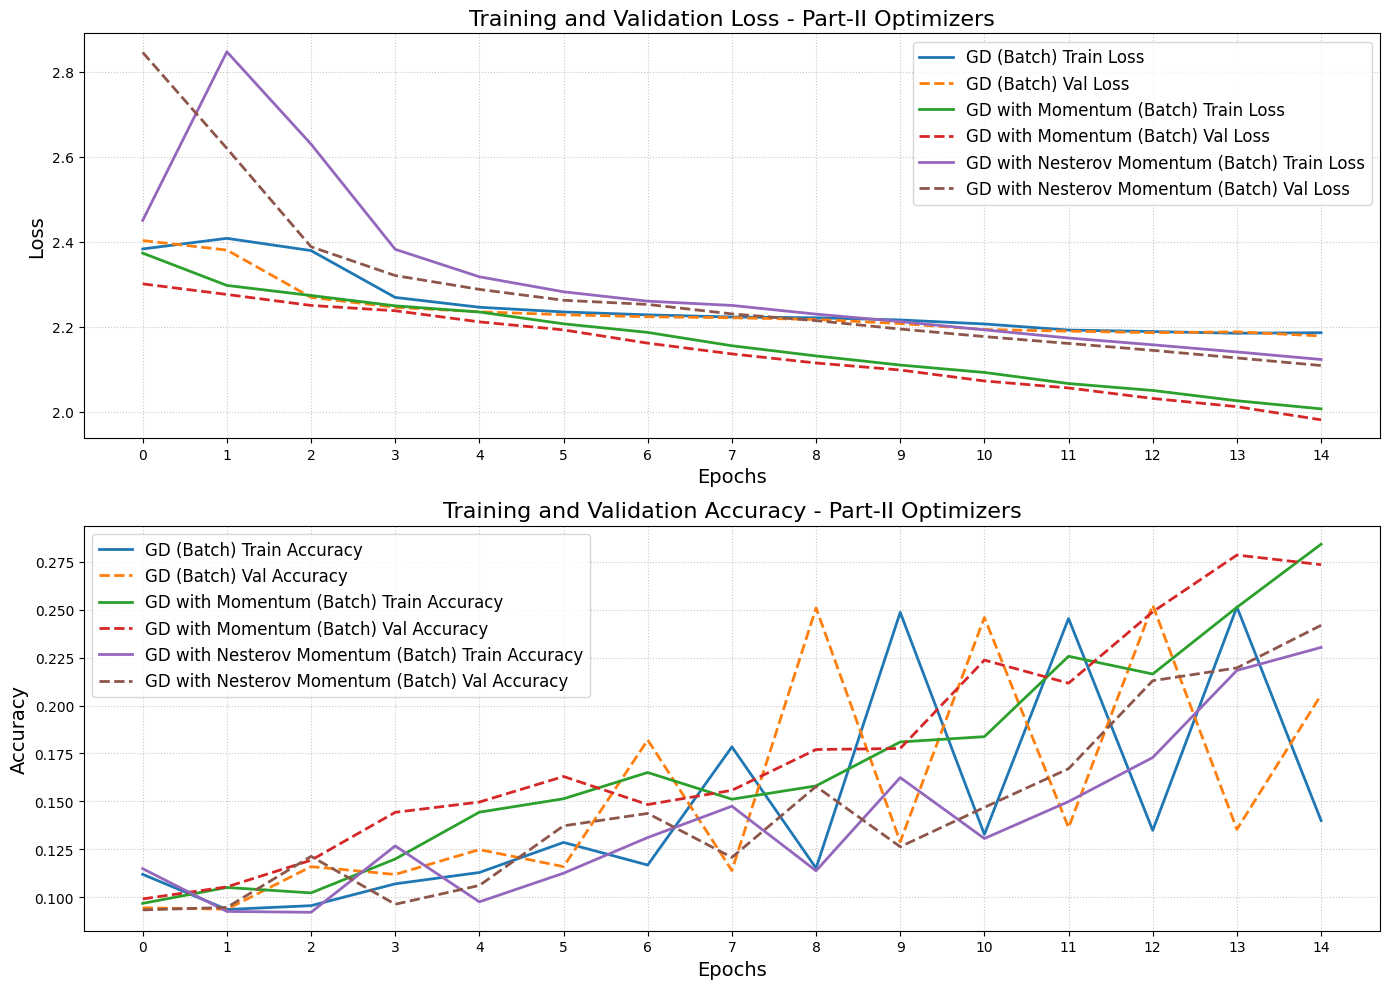

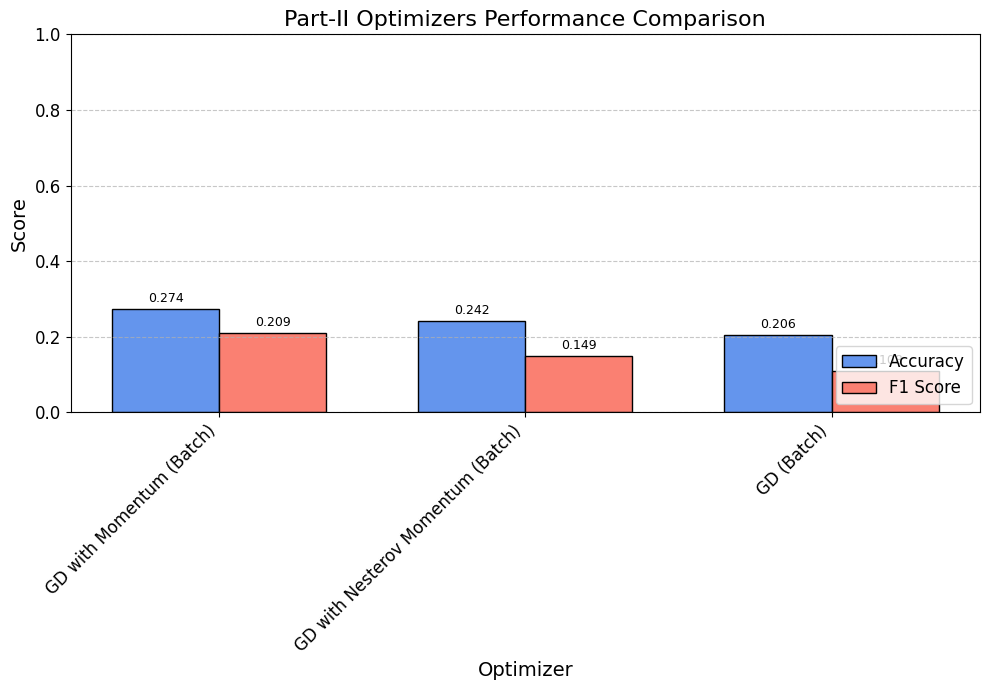

In [ ]:
part2_names = ['GD (Batch)', 'GD with Momentum (Batch)', 'GD with Nesterov Momentum (Batch)']
part2_histories_to_plot = {name: results_history[name] for name in part2_names if name in results_history}
part2_df = results_df[results_df['Optimizer'].isin(part2_names)]

print("\n\n--- Comparison: Part-II Algorithms ---")
print(part2_df.sort_values(by='F1 Score', ascending=False))

if part2_histories_to_plot:
    plot_training_history(part2_histories_to_plot, "Part-II Optimizers")
plot_comparison_bar_chart(part2_df, "Part-II Optimizers Performance Comparison")

# Comparison c) Part-III Algorithms



--- Comparison: Part-III Algorithms ---
  Optimizer        Batch Size Config  Accuracy  F1 Score  Training Time (s)
5   AdaGrad  32 (tf.data configured)  0.482778  0.467970          30.978930
7      Adam  32 (tf.data configured)  0.450926  0.411263          32.847387
6   RMSprop  32 (tf.data configured)  0.112593  0.022788          31.247896


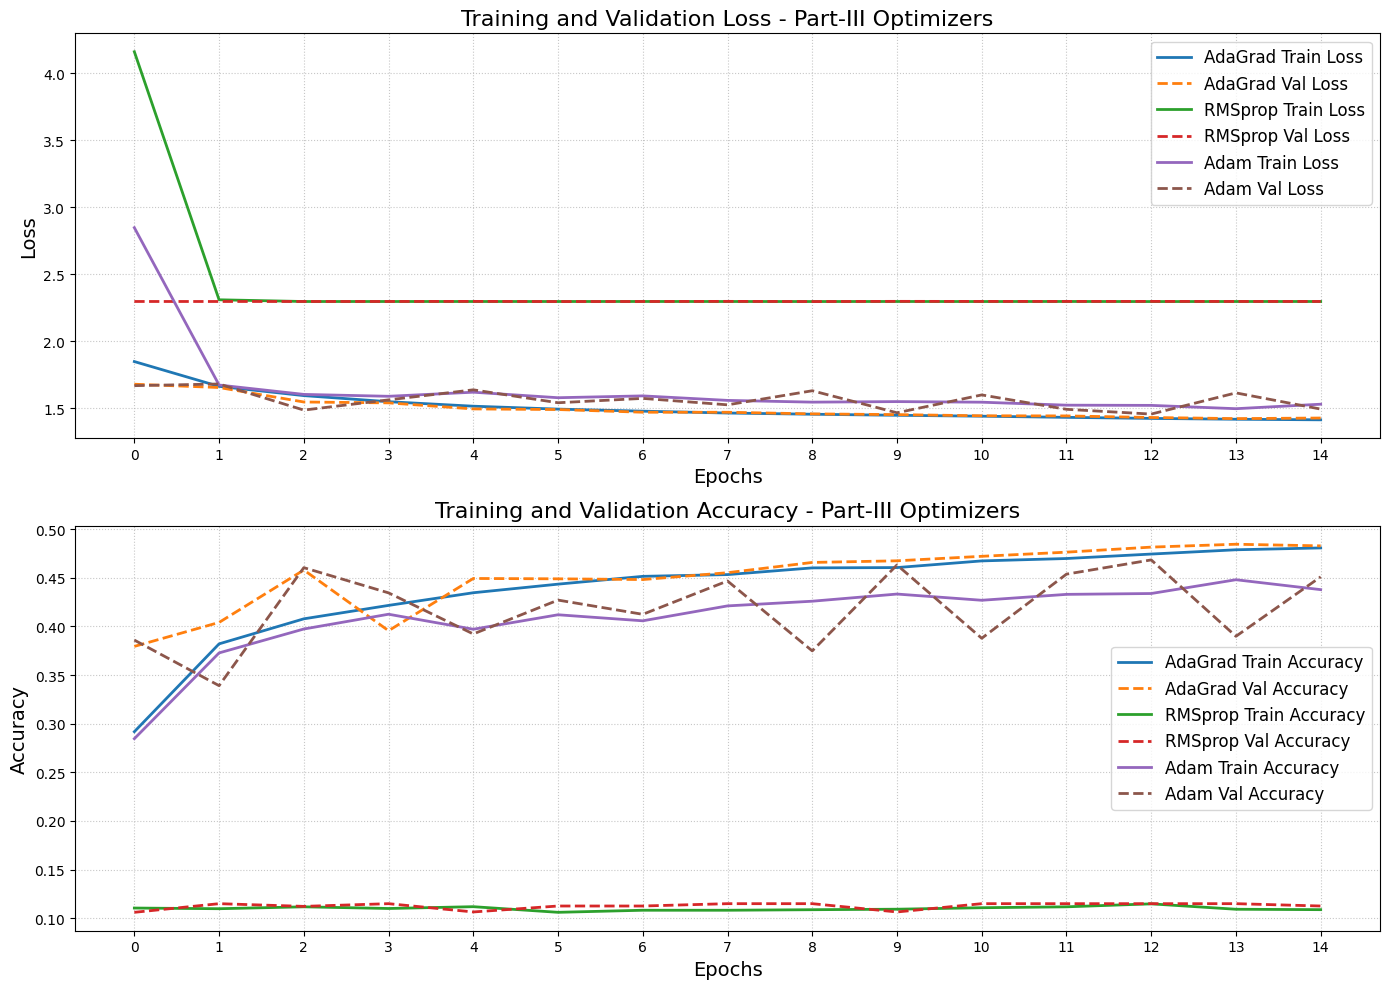

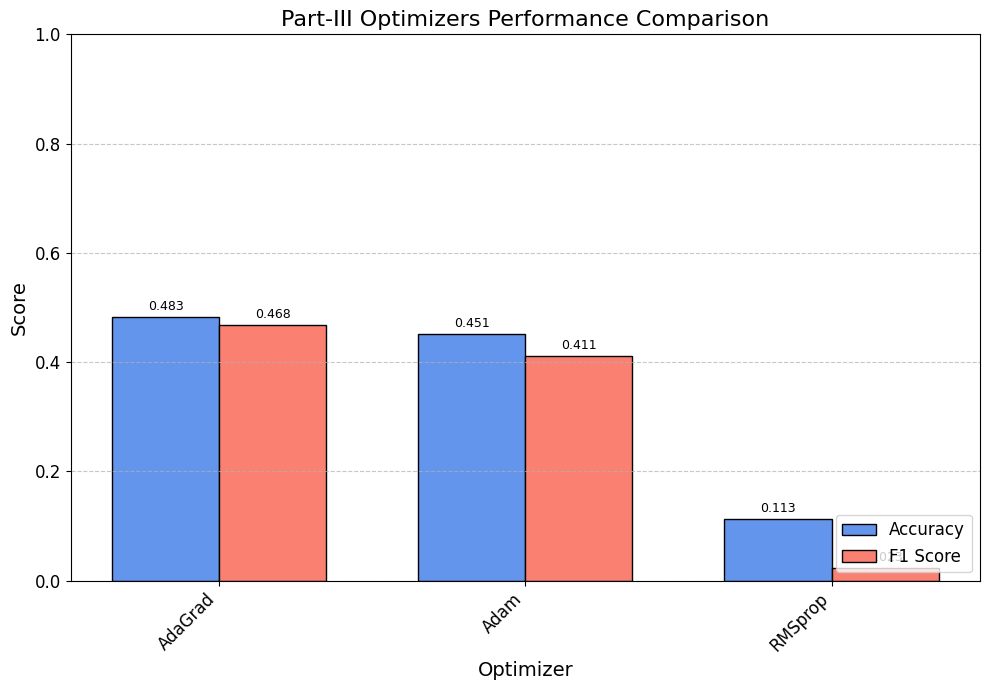

In [ ]:
part3_names = ['AdaGrad', 'RMSprop', 'Adam']
part3_histories_to_plot = {name: results_history[name] for name in part3_names if name in results_history}
part3_df = results_df[results_df['Optimizer'].isin(part3_names)]

print("\n\n--- Comparison: Part-III Algorithms ---")
print(part3_df.sort_values(by='F1 Score', ascending=False))

if part3_histories_to_plot:
    plot_training_history(part3_histories_to_plot, "Part-III Optimizers")
plot_comparison_bar_chart(part3_df, "Part-III Optimizers Performance Comparison")

# Comparison d) Best Algorithms from Each Group


Best from Part I (by F1 Score): Minibatch SGD
Best from Part II (by F1 Score): GD with Momentum (Batch)
Best from Part III (by F1 Score): AdaGrad
Unique best optimizers selected for final comparison: ['Minibatch SGD', 'GD with Momentum (Batch)', 'AdaGrad']


--- Comparison: Best Algorithms from Each Group ---
                  Optimizer        Batch Size Config  Accuracy  F1 Score  \
1             Minibatch SGD  32 (tf.data configured)  0.565370  0.555079   
5                   AdaGrad  32 (tf.data configured)  0.482778  0.467970   
3  GD with Momentum (Batch)                    21600  0.273519  0.208905   

   Training Time (s)  
1          30.728528  
5          30.978930  
3          28.193289  


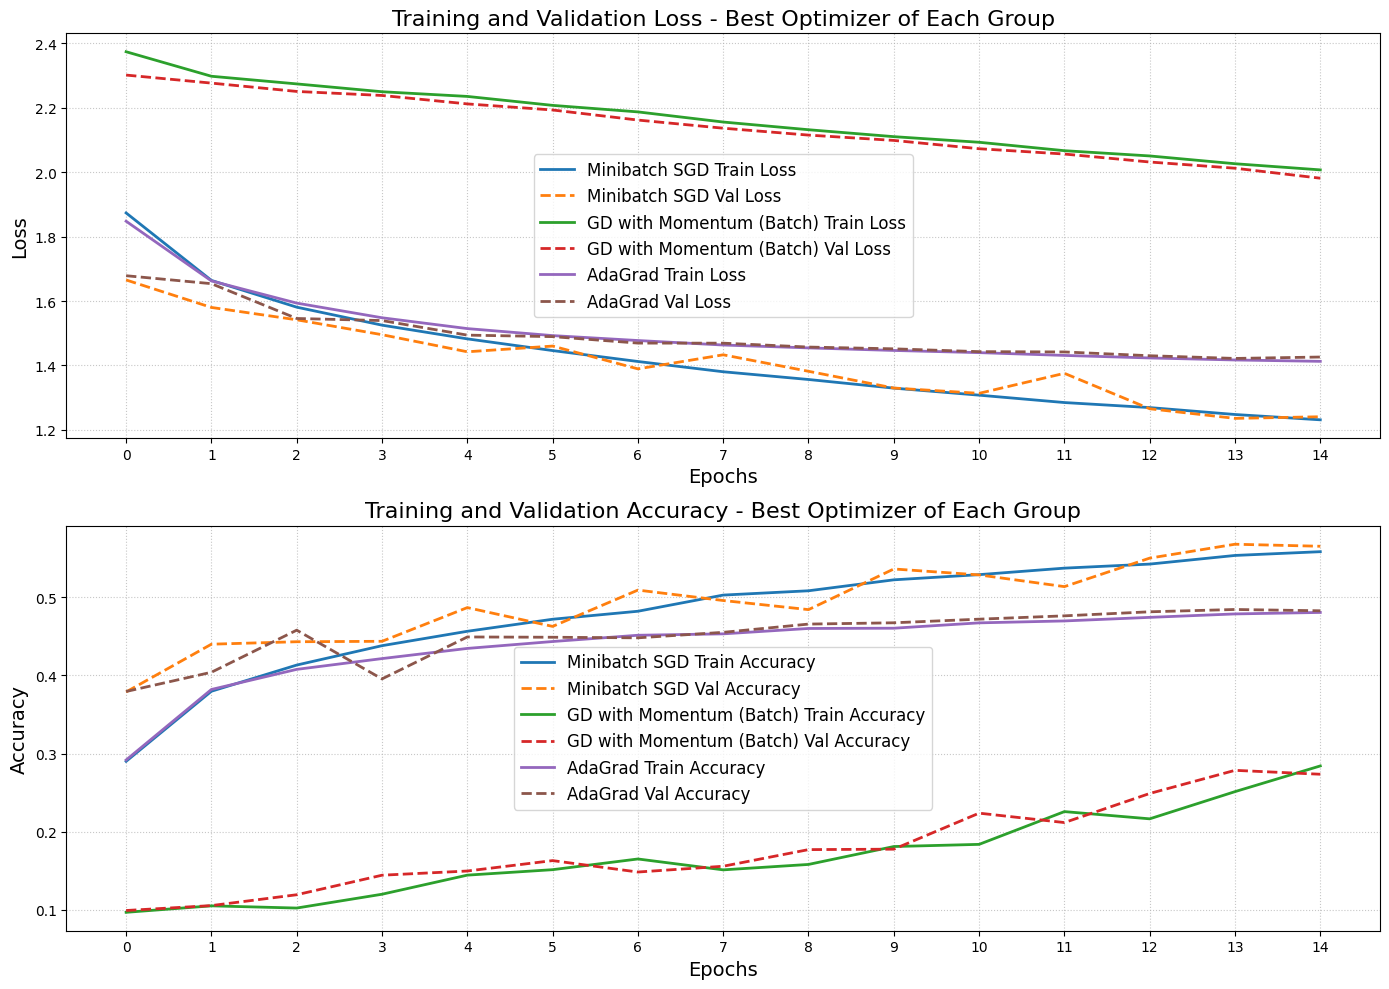

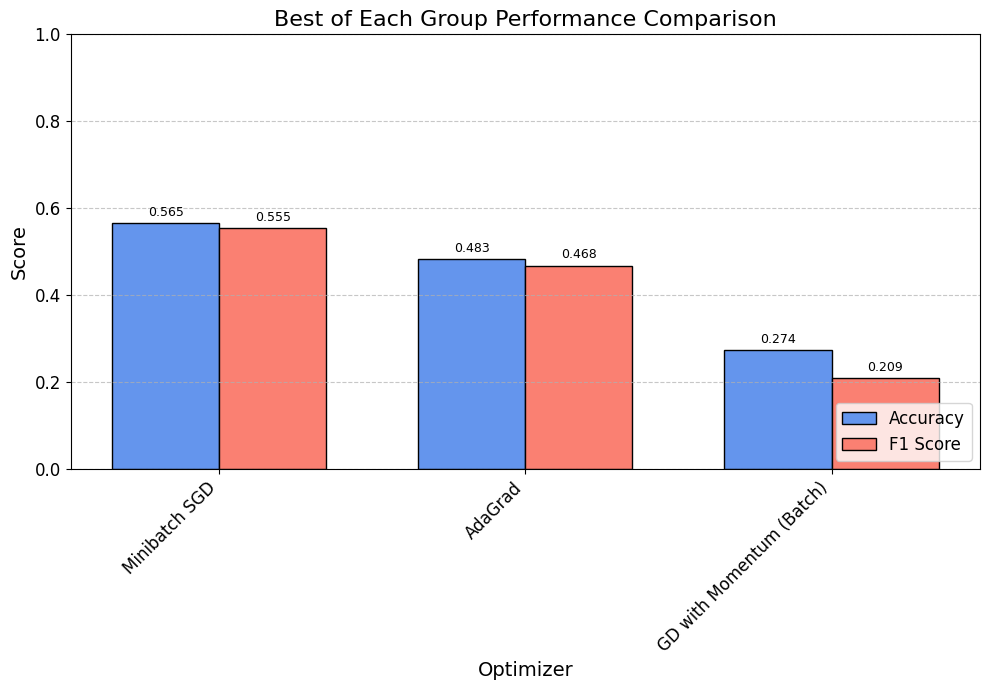

In [ ]:

best_part1_optimizer_series = part1_df.sort_values(by='F1 Score', ascending=False).iloc[0] if not part1_df.empty else None
best_part1_optimizer = best_part1_optimizer_series['Optimizer'] if best_part1_optimizer_series is not None else None


best_part2_optimizer_series = part2_df.sort_values(by='F1 Score', ascending=False).iloc[0] if not part2_df.empty else None
best_part2_optimizer = best_part2_optimizer_series['Optimizer'] if best_part2_optimizer_series is not None else None


best_part3_optimizer_series = part3_df.sort_values(by='F1 Score', ascending=False).iloc[0] if not part3_df.empty else None
best_part3_optimizer = best_part3_optimizer_series['Optimizer'] if best_part3_optimizer_series is not None else None

best_optimizers_names = list(filter(None, set([best_part1_optimizer, best_part2_optimizer, best_part3_optimizer])))

print(f"\nBest from Part I (by F1 Score): {best_part1_optimizer}")
print(f"Best from Part II (by F1 Score): {best_part2_optimizer}")
print(f"Best from Part III (by F1 Score): {best_part3_optimizer}")
print(f"Unique best optimizers selected for final comparison: {best_optimizers_names}")


best_overall_df = results_df[results_df['Optimizer'].isin(best_optimizers_names)]
best_overall_histories_to_plot = {name: results_history[name] for name in best_optimizers_names if name in results_history}

print("\n\n--- Comparison: Best Algorithms from Each Group ---")
if not best_overall_df.empty:
    print(best_overall_df.sort_values(by='F1 Score', ascending=False))
    if best_overall_histories_to_plot:
        plot_training_history(best_overall_histories_to_plot, "Best Optimizer of Each Group")
    plot_comparison_bar_chart(best_overall_df, "Best of Each Group Performance Comparison")
else:
    print("Not enough data to compare best algorithms from each group (some groups might be empty if experiments failed).")



--- Final Ranking of All Unique Optimizer Setups (Sorted by F1 Score, then Accuracy) ---
                           Optimizer        Batch Size Config  Accuracy  \
1                      Minibatch SGD  32 (tf.data configured)  0.565370   
2                            AdaGrad  32 (tf.data configured)  0.482778   
3                               Adam  32 (tf.data configured)  0.450926   
4           GD with Momentum (Batch)                    21600  0.273519   
5  GD with Nesterov Momentum (Batch)                    21600  0.241852   
6                         GD (Batch)                    21600  0.205556   
7                            RMSprop  32 (tf.data configured)  0.112593   
8                      Stochastic GD                        1  0.106111   

   F1 Score  Training Time (s)  
1  0.555079          30.728528  
2  0.467970          30.978930  
3  0.411263          32.847387  
4  0.208905          28.193289  
5  0.148987          28.029728  
6  0.108335          27.860307  
7 

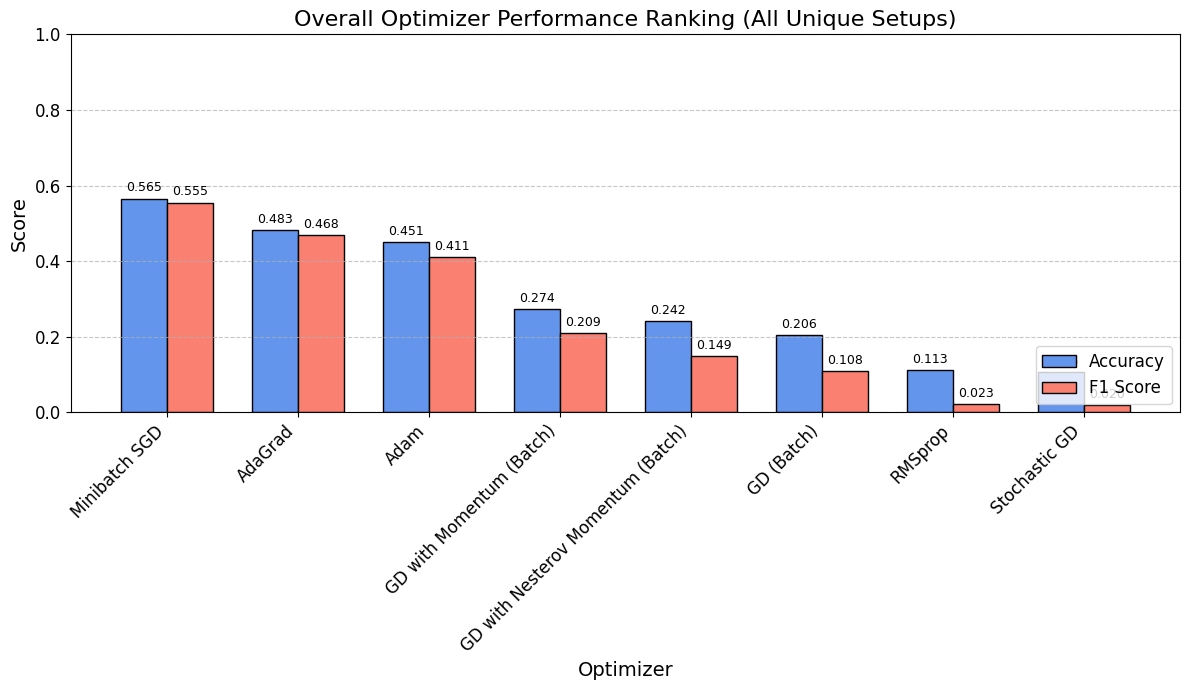

In [ ]:

all_unique_optimizers_df = results_df.copy()

print("\n\n--- Final Ranking of All Unique Optimizer Setups (Sorted by F1 Score, then Accuracy) ---")
ranked_df = all_unique_optimizers_df.sort_values(by=['F1 Score', 'Accuracy'], ascending=[False, False])
ranked_df = ranked_df.reset_index(drop=True)
ranked_df.index = ranked_df.index + 1 # Start rank from 1
print(ranked_df)

plot_comparison_bar_chart(ranked_df, "Overall Optimizer Performance Ranking (All Unique Setups)", sort_by_metric='F1 Score')